# Nerual Network Basics

## Activation Functions
- ReLU is short for “rectified linear unit,” but that is just a fancy way of saying “turn  negative values into 0.”
- Sigmoid is used in logistic regression and binary classification in general. Simply put, it normalize a value into a probability [0, 1]

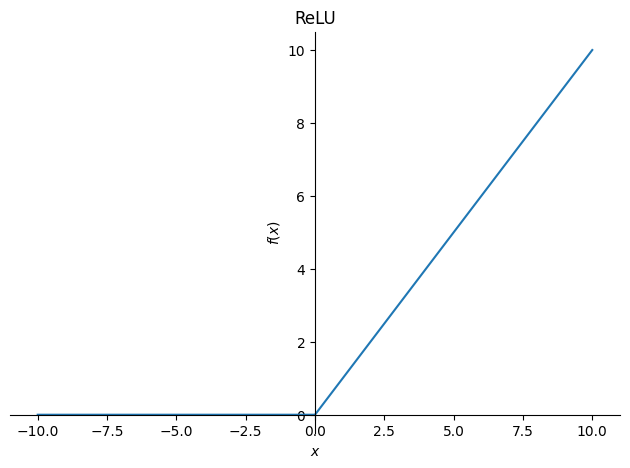

In [1]:
from sympy import *

# plot relu
x = symbols("x")
relu = Max(0, x)
plot(relu, title="ReLU")

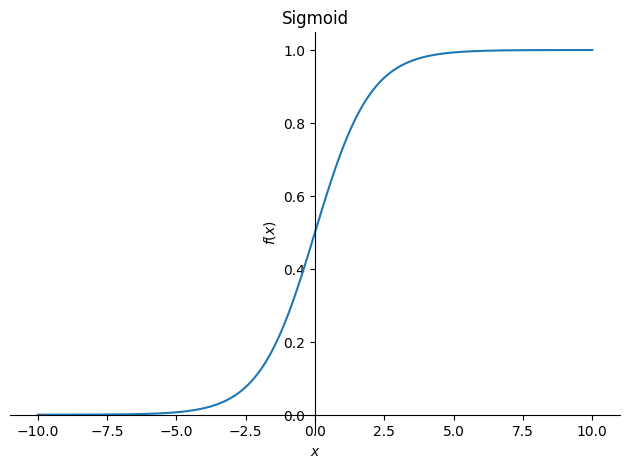

In [2]:
# plot sigmoid
x = symbols("x")
sigmoid = 1 / (1 + exp(-x))
plot(sigmoid, title="Sigmoid")

In [3]:
x,y = symbols('x y')
z = x**2 / sqrt(2*y**3 - 1)
print(latex(z))
# prints # \frac{x^{2}}{\sqrt{2 y^{3} - 1}}

\frac{x^{2}}{\sqrt{2 y^{3} - 1}}


# Implement a NN using Numpy

Goal: implement a fully-connected nn using numpy to predict digit for hand-written digit dataset

digits.data.shape: (1797, 64)
digits.images.shape: (1797, 8, 8)
digits.target.shape: (1797,)


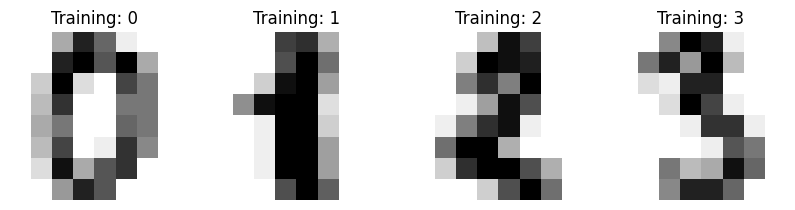

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
print(f"digits.data.shape: {digits.data.shape}")  # flattened image
print(f"digits.images.shape: {digits.images.shape}")  # 8x8 image
print(f"digits.target.shape: {digits.target.shape}")  # labels

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [5]:
# NN architecture:
# 1. input layer: 64 features (8x8 image)
# 2. hidden layer: 32 neurons
# 3. output layer: 10 neurons (0-9 digits)

# 1. initialize weights and biases
def init_params(input_size, hidden_size, output_size):
    np.random.seed(42)
    weights = {
        "W1": np.random.randn(input_size, hidden_size),
        "b1": np.zeros((1, hidden_size)),  # bias is a row vector
        "W2": np.random.randn(hidden_size, output_size),
        "b2": np.zeros((1, output_size))  # bias is a row vector
    }
    return weights

# 2. activation functions
def relu(x: np.ndarray):
    return np.maximum(0, x)

def softmax(x: np.ndarray):
    # We use softmax instead of division by sum for several reasons:
    # 1. non-linearity: exp scaling amplifies the probability of larger values and vice versa
    # 2. handles negative values: the output distribution has all positive values due to exp scaling
    # 3. sensitive to outliers
    # Note: axis=1 is for row-wise operation so we normalize each row instead of dividing the entire matrix by the sum of all exponential elements
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(shifted_x)
    return exps / np.sum(exps, axis=1, keepdims=True)
    
# 3. forward pass (Z=output from each layer, A=activated output)
def forward(X, weights):
    Z1 = X @ weights["W1"] + weights["b1"]
    A1 = relu(Z1)
    Z2 = A1 @ weights["W2"] + weights["b2"]
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# 4. loss function (aka cost or error function) -> choose categorical cross entropy
def loss(output, labels) -> float:
    """
    output dimension: (batch_size, 10)
    labels dimension: (batch_size,)
    one-hot encoding: (batch_size, 10)
    """
    N = labels.shape[0]
    # First we need to convert labels to one-hot encoding
    one_hot_labels = np.zeros((labels.shape[0], 10))
    one_hot_labels[np.arange(labels.shape[0]), labels.astype(int)] = 1
    # Then we can compute the mean loss for each batch
    # Note: we add a small epsilon to avoid log(0) which is undefined
    loss = -1 * np.sum(one_hot_labels * np.log(output + 1e-10)) / N

    return loss

# 5. backpropagation
def d_relu(x: np.ndarray):
    return np.where(x >= 0, 1, 0)

def d_softmax(x: np.ndarray):
    return x * (1 - x)

def backward(Z1, A1, Z2, A2, X, Y, weights):
    # One-hot encoding labels into (N, 10) matrix
    N = X.shape[0]
    Y_one_hot = np.zeros((N, 10))
    Y_one_hot[np.arange(N), Y] = 1

    dZ2 = (A2 - Y_one_hot) / N  # softmax cross-entropy loss simplifies to this

    # Compute gradients (note: the dimension of gradients is the same as the dimension of weights)
    # Grad for W2, b2
    dW2 = A1.T @ dZ2  # (32,N) x (N,10) => (32,10)
    db2 = np.sum(dZ2, axis=0, keepdims=True)  # (1,10)

    # Backprop to hidden layer
    dA1 = dZ2 @ weights["W2"].T  # (N,10) x (10,32) => (N,32)
    dZ1 = dA1 * d_relu(Z1)       # elementwise

    dW1 = X.T @ dZ1             # (64,N) x (N,32) => (64,32)
    db1 = np.sum(dZ1, axis=0, keepdims=True)  # (1,32)

    return dW1, db1, dW2, db2

# Accuracy Helper
def accuracy(output, labels):
    return np.sum(np.argmax(output, axis=1) == labels) / len(labels)

# 6. update weights and biases via full-batch gradient descent
loss_history = []
accuracy_history = []
epochs = 1000
learning_rate = 0.01
weights = init_params(64, 32, 10)
X, Y = digits.data, digits.target
for epoch in range(epochs):
    Z1, A1, Z2, A2 = forward(X, weights)
    dLoss_dW1, dLoss_db1, dLoss_dW2, dLoss_db2 = backward(Z1, A1, Z2, A2, X, Y, weights)
    weights["W1"] -= learning_rate * dLoss_dW1
    weights["b1"] -= learning_rate * dLoss_db1
    weights["W2"] -= learning_rate * dLoss_dW2
    weights["b2"] -= learning_rate * dLoss_db2

    if epoch % 50 == 0:
        loss_value = loss(A2, Y)
        print(f"Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy(A2, Y)}")
        loss_history.append([epoch, loss_value])
        accuracy_history.append([epoch, accuracy(A2, Y)])




Epoch 0, Loss: 20.719421788367118, Accuracy: 0.1001669449081803
Epoch 50, Loss: 4.467597804867049, Accuracy: 0.7595993322203672
Epoch 100, Loss: 2.5301654517174854, Accuracy: 0.8480801335559266
Epoch 150, Loss: 1.781423187980637, Accuracy: 0.8898163606010017
Epoch 200, Loss: 1.368541901347957, Accuracy: 0.9098497495826378
Epoch 250, Loss: 1.1160853524703778, Accuracy: 0.9254312743461325
Epoch 300, Loss: 0.8960723014054227, Accuracy: 0.9326655537006121
Epoch 350, Loss: 0.7163951168980481, Accuracy: 0.9404563160823595
Epoch 400, Loss: 0.5859877293744268, Accuracy: 0.9476905954368392
Epoch 450, Loss: 0.49942980572120105, Accuracy: 0.9565943238731218
Epoch 500, Loss: 0.43089668954992083, Accuracy: 0.9604897050639956
Epoch 550, Loss: 0.38375787523448, Accuracy: 0.9643850862548692
Epoch 600, Loss: 0.34598548924375455, Accuracy: 0.9693934335002783
Epoch 650, Loss: 0.3189449376182225, Accuracy: 0.9710628825820813
Epoch 700, Loss: 0.29723030885579793, Accuracy: 0.9760712298274903
Epoch 750, Los

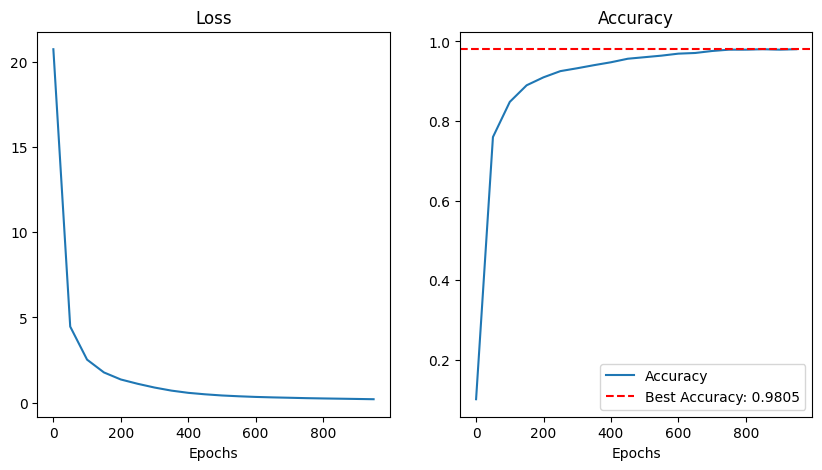

In [6]:
# Plot loss and accuracy as two separate plots with x-axis as epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in loss_history], [x[1] for x in loss_history], label="Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in accuracy_history], [x[1] for x in accuracy_history], label="Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
# Insert a horizontal dotted line at the best accuracy and label the accuracy
best_accuracy = max([x[1] for x in accuracy_history])
plt.axhline(y=best_accuracy, color='red', linestyle='--', label=f"Best Accuracy: {best_accuracy:.4f}")
plt.legend()
plt.show()

